In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm

In [3]:
df = pl.read_csv("gambia.csv")
df

x,y,pos,age,netuse,treated,green,phc
f64,i64,i64,i64,i64,i64,f64,i64
349631.3,1458055,1,1783,0,0,40.85,1
349631.3,1458055,0,404,1,0,40.85,1
349631.3,1458055,0,452,1,0,40.85,1
349631.3,1458055,1,566,1,0,40.85,1
349631.3,1458055,0,598,1,0,40.85,1
…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1
622086.1,1474011,1,1704,1,0,50.1,1
622086.1,1474011,1,1733,0,0,50.1,1


In [4]:
y = df.get_column("pos").to_numpy()
X = df.select("age", "netuse", "treated", "green", "phc").to_numpy()
y

array([1, 0, 0, ..., 1, 0, 0], shape=(2035,))

In [5]:
X_std = (X - X.mean(0)) / X.std(0)
X_std

array([[ 1.65055383, -1.56872061, -0.61692545, -0.84646886,  0.6804236 ],
       [-1.58918131,  0.63746214, -0.61692545, -0.84646886,  0.6804236 ],
       [-1.47641315,  0.63746214, -0.61692545, -0.84646886,  0.6804236 ],
       ...,
       [ 1.533087  , -1.56872061, -0.61692545,  0.44666349,  0.6804236 ],
       [ 1.74922597, -1.56872061, -0.61692545,  0.44666349,  0.6804236 ],
       [ 1.77506867,  0.63746214, -0.61692545,  0.44666349,  0.6804236 ]],
      shape=(2035, 5))

In [6]:
def WGBP(a, b, lam, b0, theta, mu, sigma2, disp):
    tau = np.linspace(0.01, 0.99, num=100)

    w = qw(p=tau, a=a, b=b, b0=b0, theta=theta, mu=mu, sigma2=sigma2, disp=disp)
    py = dw(w=w, a=a, b=b, b0=b0, theta=theta, mu=mu, sigma2=sigma2, disp=disp)

    

In [8]:
from scipy import stats

def expit(x):
    return 1 / (1 + np.exp(-x))


def W_to_R2_inner(x, b0):
    K = 1000
    p_grid = np.linspace(1, K - 1, num=K - 1) / K

    probs = expit(stats.norm(loc=b0, scale=x ** 0.5).ppf(p_grid))

    M = np.sum(probs ** 2) / (K - 1) - (np.sum(probs) / (K - 1)) ** 2
    V = np.sum(probs * (1 - probs)) / (K - 1)
    return M / (M + V)


def W_to_R2(W, b0):
    return np.array([W_to_R2_inner(w, b0) for w in np.atleast_1d(W)])


def pw(W, a, b, b0):
    R2 = W_to_R2(W, b0)
    return stats.beta.cdf(R2, a=a, b=b)


# def qw(p, a, b, b0):
#     def inner

In [ ]:
# qw <- function(p, a=1, b=1, b0=0, link=c("Gaussian", "Logistic", "Poisson", "Poisson_offsets",
#                                          "ZIP", "NegBinom", "Weibull", "Arbitrary"),
#                theta=1, mu, sigma2, disp=FALSE){

#   apply.fun <- function(p){
#     dist <- function(logw){
#       return(
#         (r2d2glmm::pw(w=exp(logw), a=a, b=b, b0=b0,link=link,
#                       theta=theta,mu=mu,sigma2=sigma2,disp=disp) - p)^2
#       )
#     }

#     out <- stats::optimize(dist, lower=log(1/100000), upper=log(100000))$min

#     return(exp(out))
#   }

#   return(
#     sapply(p, apply.fun)
#   )

# }

array([0.17279408, 0.27297423, 0.34198904, 0.39369128, 0.43446098,
       0.46775659, 0.49565494, 0.5194954 , 0.54018865, 0.55837986])

In [ ]:
# WGBP <- function(a=1, b=1, lambda=0.25, b0=0,
#                  link=c("Logistic", "Poisson", "Poisson_offsets",
#                                                            "ZIP", "NegBinom", "Weibull", "Arbitrary"),
#                  theta=1, mu, sigma2, disp=FALSE){

#   tau <- seq(0.01, 0.99, length=100)

#   w <- r2d2glmm::qw(p=tau, a=a, b=b, b0=b0,link=link,theta=theta,mu=mu,sigma2=sigma2,disp=disp)
#   py <- r2d2glmm::dw(w=w, a=a, b=b, b0=b0,link=link,theta=theta,mu=mu,sigma2=sigma2,disp=disp)
  
#   w <- w[!is.na(py)]
#   py <- py[!is.na(py)]

#   dist <- function(logparam){# Distance between W and W'
#     px <- r2d2glmm::dgbetapr(w, exp(logparam[1]),exp(logparam[2]),exp(logparam[3]), exp(logparam[4]))[!is.na(py)]

#     return(sum((1-px/py)^2) + lambda *( (logparam[1]-log(a))^2 + (logparam[2]-log(b))^2 +sdasd
#                                           (logparam[3]-log(1))^2 + (logparam[4]-log(1))^2  ))

#   }

#   return(asd
#     exp(stats::optim(c(log(1), log(1),  log(1), log(1)), dist)$par)
#   )
# }

In [9]:
params = np.array([1.4722786, 0.6494361, 0.7887448, 1.6711417])

In [10]:
X_std.shape

(2035, 5)

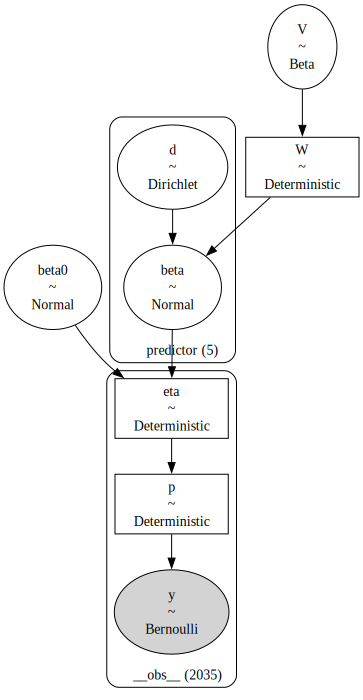

In [12]:
coords = {
    "predictor": ["age", "netuse", "treated", "green", "phc"],
    "__obs__": np.arange(X_std.shape[0])
}

with pm.Model(coords=coords) as model:
    V = pm.Beta("V", alpha=params[0], beta=params[1])
    W = pm.Deterministic("W", (V / (1 - V)) ** (1 / params[2]) * params[3])
    d = pm.Dirichlet("d", a=np.ones(5), dims="predictor")

    beta0 = pm.Normal("beta0", mu=0, sigma=3 ** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=(W * d) ** 0.5, dims="predictor")

    eta = pm.Deterministic("eta", beta0 + X_std @ beta, dims="__obs__")
    p = pm.Deterministic("p", pm.math.sigmoid(eta), dims="__obs__")
    pm.Bernoulli("y", p=p, observed=y, dims="__obs__")

model.to_graphviz()

In [13]:
with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [V, d, beta0, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


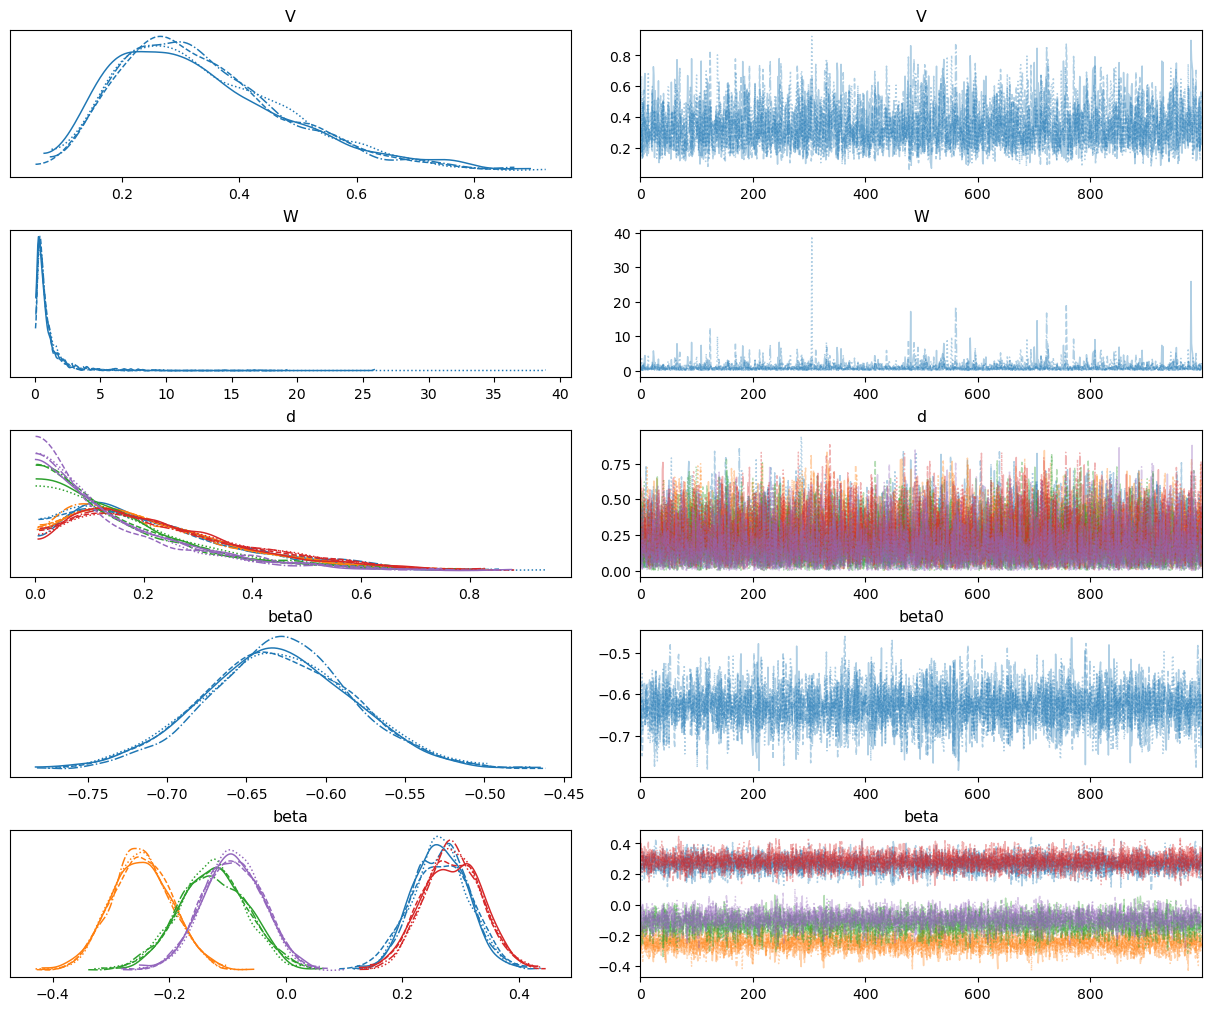

In [14]:
az.plot_trace(idata, var_names=["V", "W", "d", "beta0", "beta"], backend_kwargs={"layout": "constrained"});